## Dataset Description - 

- <u>id</u> - Unique identifier of a customer
- <u>gender</u> - Gender of the customer
- <u>area</u> - Area of the customer
- <u>qualification</u> - Highest Qualification of the customer
- <u>income</u> - Income earned in a year (in rupees)
- <u>marital_status</u> - Marital Status of the customer {0:Single, 1: Married}
- <u>vintage</u> - No. of years since the first policy date
- <u>claim_amount</u> - Total Amount Claimed by the customer (in rupees)
- <u>num_policies</u> - Total no. of policies issued by the customer
- <u>policy</u> - Active policy of the customer
- <u>type_of_policy</u> - Type of active policy
- <u>cltv</u> - Customer lifetime value (Target Variable)

In [5]:
import warnings
warnings.simplefilter('ignore')

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fast_ml.feature_selection import get_constant_features

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import PowerTransformer, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import os
from sklearn.ensemble import RandomForestRegressor
import lightgbm
import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from keras.regularizers import l2



%matplotlib inline

In [7]:
train = pd.read_csv('C:/Users/rsk13/Desktop/CLTV/data_source/train_BRCpofr.csv')
train.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


In [8]:
test = pd.read_csv('C:/Users/rsk13/Desktop/CLTV/data_source/test_koRSKBP.csv')
test.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy
0,89393,Female,Rural,High School,5L-10L,0,6,2134,More than 1,B,Silver
1,89394,Female,Urban,High School,2L-5L,0,4,4102,More than 1,A,Platinum
2,89395,Male,Rural,High School,5L-10L,1,7,2925,More than 1,B,Gold
3,89396,Female,Rural,Bachelor,More than 10L,1,2,0,More than 1,B,Silver
4,89397,Female,Urban,High School,2L-5L,0,5,14059,More than 1,B,Silver


In [9]:
train.shape[0] + test.shape[0]

148987

In [10]:
train

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736
...,...,...,...,...,...,...,...,...,...,...,...,...
89387,89388,Male,Rural,High School,More than 10L,0,6,0,More than 1,B,Platinum,95736
89388,89389,Male,Urban,Bachelor,5L-10L,1,0,3897,More than 1,A,Platinum,67596
89389,89390,Female,Urban,Bachelor,5L-10L,0,4,3363,More than 1,B,Platinum,114120
89390,89391,Female,Rural,High School,2L-5L,0,8,0,More than 1,B,Platinum,71772


In [11]:
train.shape

(89392, 12)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89392 entries, 0 to 89391
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              89392 non-null  int64 
 1   gender          89392 non-null  object
 2   area            89392 non-null  object
 3   qualification   89392 non-null  object
 4   income          89392 non-null  object
 5   marital_status  89392 non-null  int64 
 6   vintage         89392 non-null  int64 
 7   claim_amount    89392 non-null  int64 
 8   num_policies    89392 non-null  object
 9   policy          89392 non-null  object
 10  type_of_policy  89392 non-null  object
 11  cltv            89392 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 8.2+ MB


In [13]:
train.describe()

,id,marital_status,vintage,claim_amount,cltv
count,89392.000000,89392.000000,89392.000000,89392.000000,89392.000000
mean,44696.500000,0.575488,4.595669,4351.502416,97952.828978
std,25805.391969,0.494272,2.290446,3262.359775,90613.814793
min,1.000000,0.000000,0.000000,0.000000,24828.000000
25%,22348.750000,0.000000,3.000000,2406.000000,52836.000000
50%,44696.500000,1.000000,5.000000,4089.000000,66396.000000
75%,67044.250000,1.000000,6.000000,6094.000000,103440.000000
max,89392.000000,1.000000,8.000000,31894.000000,724068.000000


### Observations:

1. The dataset does not contain any null values.

2. The vintage feature exhibits consistency, with the mean and standard deviation being close together, indicating a moderate spread of values.

3. A significant portion of claim amounts have a minimum value of 0. This could suggest that some customers either haven't made any claims yet or are new to the system. This observation is further supported by the minimum value of vintage, indicating the presence of customers who have yet to initiate their first policy.

## Data Preprocessing/Analysis/Engineering

In [14]:
train

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736
...,...,...,...,...,...,...,...,...,...,...,...,...
89387,89388,Male,Rural,High School,More than 10L,0,6,0,More than 1,B,Platinum,95736
89388,89389,Male,Urban,Bachelor,5L-10L,1,0,3897,More than 1,A,Platinum,67596
89389,89390,Female,Urban,Bachelor,5L-10L,0,4,3363,More than 1,B,Platinum,114120
89390,89391,Female,Rural,High School,2L-5L,0,8,0,More than 1,B,Platinum,71772


- We can drop Id column as it will not be useful. 

In [15]:
train.drop(columns = ['id'], axis = 1, inplace = True)

In [16]:
train.head()

,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


#### Constant/Quasi-Constant Features

In [17]:
get_constant_features(train)

,Desc,Var,Value,Perc


#### Duplications

In [18]:
train.duplicated().sum()

26

In [19]:
train.T.duplicated().sum()

0

In [20]:
train.head()

,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


### Feature Engineering/Selection/Handling

#### Income column

In [21]:
train['income'].value_counts()

income
5L-10L           52716
2L-5L            21158
More than 10L    13664
<=2L              1854
Name: count, dtype: int64

- Mapping the values in this column to numbers based on their importance is the most practical and straightforward approach.

- This mapping can then be leveraged to identify and address any skewed data distribution.

- Given the ordinal nature of the data, this method proves to be effective in handling the column.

In [22]:
train['income'] = train['income'].map({'<=2L': 1, '2L-5L': 2, '5L-10L': 3, 'More than 10L': 4})
train['income'].value_counts()

income
3    52716
2    21158
4    13664
1     1854
Name: count, dtype: int64

#### Num_policies column

In [23]:
train['num_policies'].value_counts()

num_policies
More than 1    60263
1              29129
Name: count, dtype: int64

- The same thing can be done to this column like the income column.
- 2 will be considered more than 1. 

In [24]:
train['num_policies'] = train['num_policies'].map({'1': 1, 'More than 1':2})
train['num_policies'].value_counts()

num_policies
2    60263
1    29129
Name: count, dtype: int64

#### Outlier Analysis

In [25]:
train.dtypes

gender            object
area              object
qualification     object
income             int64
marital_status     int64
vintage            int64
claim_amount       int64
num_policies       int64
policy            object
type_of_policy    object
cltv               int64
dtype: object

In [26]:
numerical_columns = train.select_dtypes(include = ['int64']).columns
numerical_columns = train[numerical_columns]
numerical_columns

,income,marital_status,vintage,claim_amount,num_policies,cltv
0,3,1,5,5790,2,64308
1,3,0,8,5080,2,515400
2,3,1,8,2599,2,64212
3,3,0,7,0,2,97920
4,4,1,6,3508,2,59736
...,...,...,...,...,...,...
89387,4,0,6,0,2,95736
89388,3,1,0,3897,2,67596
89389,3,0,4,3363,2,114120
89390,2,0,8,0,2,71772


In [27]:
train['claim_amount']

0        5790
1        5080
2        2599
3           0
4        3508
         ... 
89387       0
89388    3897
89389    3363
89390       0
89391       0
Name: claim_amount, Length: 89392, dtype: int64

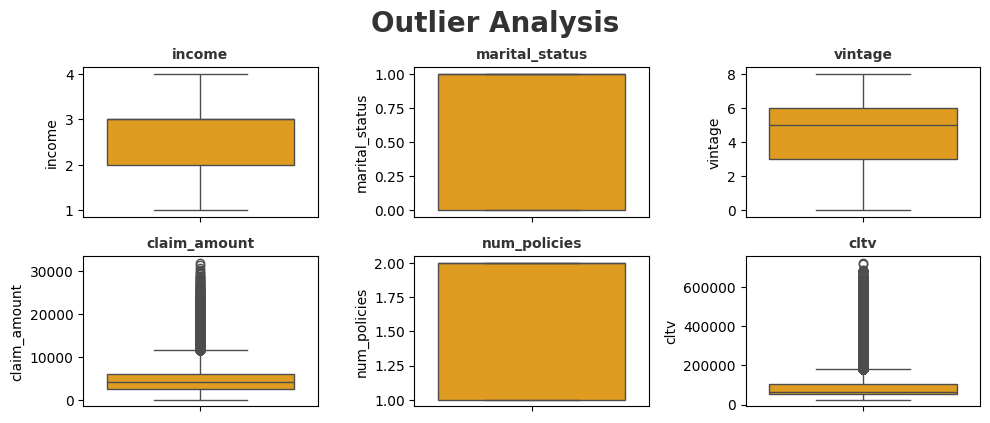

In [28]:
plt.figure(figsize=(10, 10))
plt.suptitle('Outlier Analysis', fontsize=20, fontweight='bold', alpha=0.8)

for i, column in enumerate(numerical_columns.columns):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(numerical_columns[column], color='orange')
    plt.title(column, fontsize=10, fontweight='bold', alpha=0.8)
    plt.tight_layout()

plt.show()

### Observations -

1. Apart from claim_amount, no significant outliers are apparent in the dataset.

2. Considering that claim_amount represents the total amount claimed by customers, it is essential not to disregard potential outliers as they can provide valuable insights into calculating CLTV.

3. Consequently, it's decided not to address outliers in this analysis.

In [29]:
train

,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,Male,Urban,Bachelor,3,1,5,5790,2,A,Platinum,64308
1,Male,Rural,High School,3,0,8,5080,2,A,Platinum,515400
2,Male,Urban,Bachelor,3,1,8,2599,2,A,Platinum,64212
3,Female,Rural,High School,3,0,7,0,2,A,Platinum,97920
4,Male,Urban,High School,4,1,6,3508,2,A,Gold,59736
...,...,...,...,...,...,...,...,...,...,...,...
89387,Male,Rural,High School,4,0,6,0,2,B,Platinum,95736
89388,Male,Urban,Bachelor,3,1,0,3897,2,A,Platinum,67596
89389,Female,Urban,Bachelor,3,0,4,3363,2,B,Platinum,114120
89390,Female,Rural,High School,2,0,8,0,2,B,Platinum,71772


In [30]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]

print(X.shape, y.shape)

(89392, 10) (89392,)


## Handling Categorical columns

In [31]:
# Gender column - one hot encoding
# To avoid any ordinal relationship, we will use this method.

gender = pd.get_dummies(X['gender'], drop_first = True).astype(int)

X = pd.concat([X, gender], axis = 1)
X.drop(columns = ['gender'], axis = 1, inplace = True)

X

,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,Male
0,Urban,Bachelor,3,1,5,5790,2,A,Platinum,1
1,Rural,High School,3,0,8,5080,2,A,Platinum,1
2,Urban,Bachelor,3,1,8,2599,2,A,Platinum,1
3,Rural,High School,3,0,7,0,2,A,Platinum,0
4,Urban,High School,4,1,6,3508,2,A,Gold,1
...,...,...,...,...,...,...,...,...,...,...
89387,Rural,High School,4,0,6,0,2,B,Platinum,1
89388,Urban,Bachelor,3,1,0,3897,2,A,Platinum,1
89389,Urban,Bachelor,3,0,4,3363,2,B,Platinum,0
89390,Rural,High School,2,0,8,0,2,B,Platinum,0


In [32]:
X['area'].value_counts()

area
Urban    62455
Rural    26937
Name: count, dtype: int64

In [33]:
## one-hot encoding for area column

area = pd.get_dummies(X['area'], drop_first = True).astype(int)

X = pd.concat([X, area], axis = 1)
X.drop(columns = ['area'], axis = 1, inplace = True)

X

,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,Male,Urban
0,Bachelor,3,1,5,5790,2,A,Platinum,1,1
1,High School,3,0,8,5080,2,A,Platinum,1,0
2,Bachelor,3,1,8,2599,2,A,Platinum,1,1
3,High School,3,0,7,0,2,A,Platinum,0,0
4,High School,4,1,6,3508,2,A,Gold,1,1
...,...,...,...,...,...,...,...,...,...,...
89387,High School,4,0,6,0,2,B,Platinum,1,0
89388,Bachelor,3,1,0,3897,2,A,Platinum,1,1
89389,Bachelor,3,0,4,3363,2,B,Platinum,0,1
89390,High School,2,0,8,0,2,B,Platinum,0,0


In [34]:
X['qualification'].value_counts()

qualification
High School    46247
Bachelor       39399
Others          3746
Name: count, dtype: int64

- The challenge with this column lies in its values. If the qualifications were, for instance, "High School," "Bachelor," and "Masters," mapping them to values based on their ordinal relationship would be straightforward.

- However, the inclusion of "Others" complicates matters, as it's unclear whether it ranks below "High School" or above "Bachelor."

- To mitigate potential inaccuracies in encoding and ensure that our business outcomes are not compromised, it's prudent to employ one-hot encoding for this column.

In [35]:
qualifications = pd.get_dummies(X['qualification'], drop_first = True).astype(int)

X = pd.concat([X, qualifications], axis = 1)
X.drop(columns = ['qualification'], axis = 1, inplace = True)

X

,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,Male,Urban,High School,Others
0,3,1,5,5790,2,A,Platinum,1,1,0,0
1,3,0,8,5080,2,A,Platinum,1,0,1,0
2,3,1,8,2599,2,A,Platinum,1,1,0,0
3,3,0,7,0,2,A,Platinum,0,0,1,0
4,4,1,6,3508,2,A,Gold,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
89387,4,0,6,0,2,B,Platinum,1,0,1,0
89388,3,1,0,3897,2,A,Platinum,1,1,0,0
89389,3,0,4,3363,2,B,Platinum,0,1,0,0
89390,2,0,8,0,2,B,Platinum,0,0,1,0


In [36]:
X['policy'].value_counts()

policy
A    56644
B    24635
C     8113
Name: count, dtype: int64

In [37]:
policy = pd.get_dummies(X['policy'], drop_first = True).astype(int)

X = pd.concat([X, policy], axis = 1)
X.drop(columns = ['policy'], axis = 1, inplace = True)

X

,income,marital_status,vintage,claim_amount,num_policies,type_of_policy,Male,Urban,High School,Others,B,C
0,3,1,5,5790,2,Platinum,1,1,0,0,0,0
1,3,0,8,5080,2,Platinum,1,0,1,0,0,0
2,3,1,8,2599,2,Platinum,1,1,0,0,0,0
3,3,0,7,0,2,Platinum,0,0,1,0,0,0
4,4,1,6,3508,2,Gold,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
89387,4,0,6,0,2,Platinum,1,0,1,0,1,0
89388,3,1,0,3897,2,Platinum,1,1,0,0,0,0
89389,3,0,4,3363,2,Platinum,0,1,0,0,1,0
89390,2,0,8,0,2,Platinum,0,0,1,0,1,0


In [38]:
X['type_of_policy'].value_counts()

type_of_policy
Platinum    47796
Silver      21010
Gold        20586
Name: count, dtype: int64

In [39]:
X['type_of_policy'] = X['type_of_policy'].map({'Silver' : 1, 'Gold' : 2, 'Platinum' : 3})

In [40]:
X

,income,marital_status,vintage,claim_amount,num_policies,type_of_policy,Male,Urban,High School,Others,B,C
0,3,1,5,5790,2,3,1,1,0,0,0,0
1,3,0,8,5080,2,3,1,0,1,0,0,0
2,3,1,8,2599,2,3,1,1,0,0,0,0
3,3,0,7,0,2,3,0,0,1,0,0,0
4,4,1,6,3508,2,2,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
89387,4,0,6,0,2,3,1,0,1,0,1,0
89388,3,1,0,3897,2,3,1,1,0,0,0,0
89389,3,0,4,3363,2,3,0,1,0,0,1,0
89390,2,0,8,0,2,3,0,0,1,0,1,0


### Feature Selection (exclusive)

In [41]:
importance = mutual_info_regression(X, y)

df_importance = pd.DataFrame(importance, index = X.columns, columns = ['Importance'])
df_importance.nlargest(10, 'Importance')

,Importance
num_policies,0.253247
claim_amount,0.032217
Urban,0.013630
income,0.011741
B,0.011147
marital_status,0.007901
C,0.007802
vintage,0.003627
type_of_policy,0.003185
Others,0.003046


### Distribution for scaling

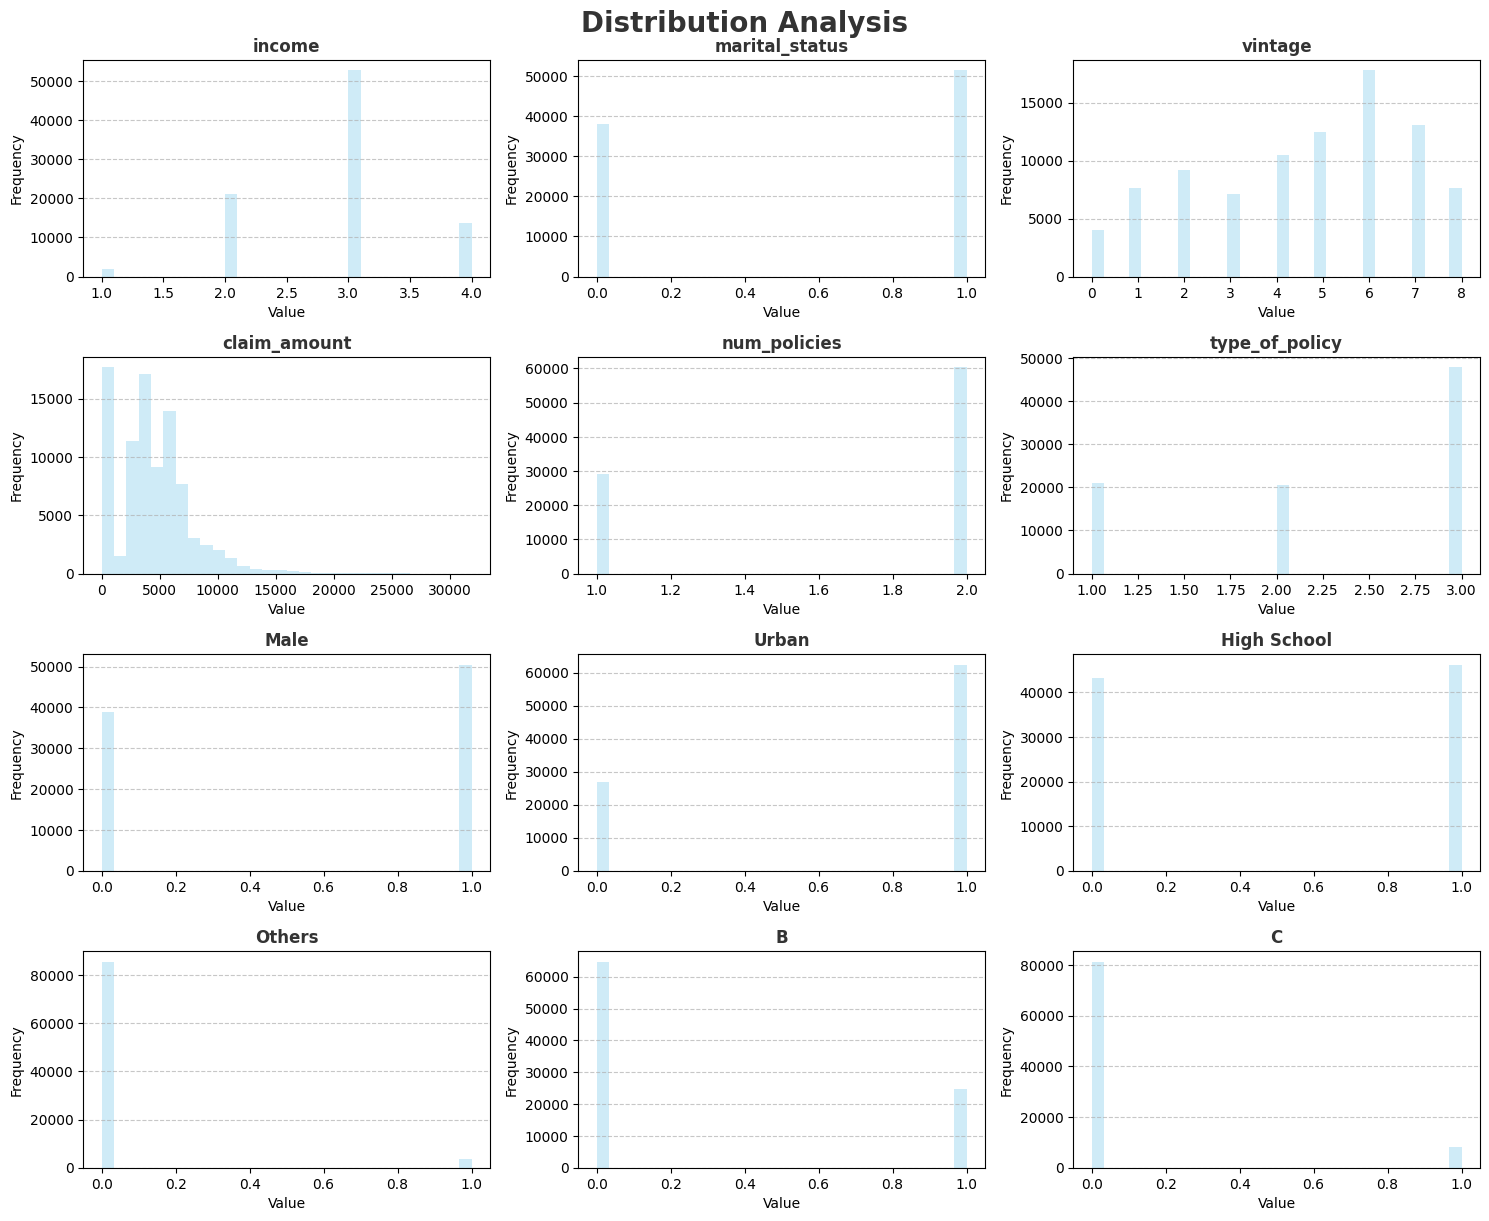

In [42]:
plt.figure(figsize=(15, 15))
plt.suptitle('Distribution Analysis', fontsize=20, fontweight='bold', alpha=0.8)

for i, column in enumerate(X.columns):
    plt.subplot(5, 3, i + 1)
    sns.distplot(X[column], kde=False, bins=30, color='skyblue')
    plt.title(column, fontsize=12, fontweight='bold', alpha=0.8)
    plt.xlabel('Value', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

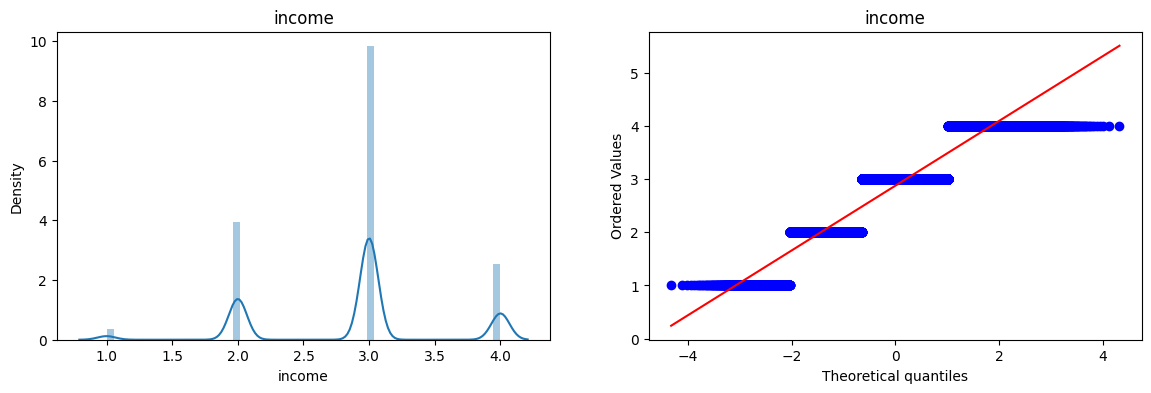

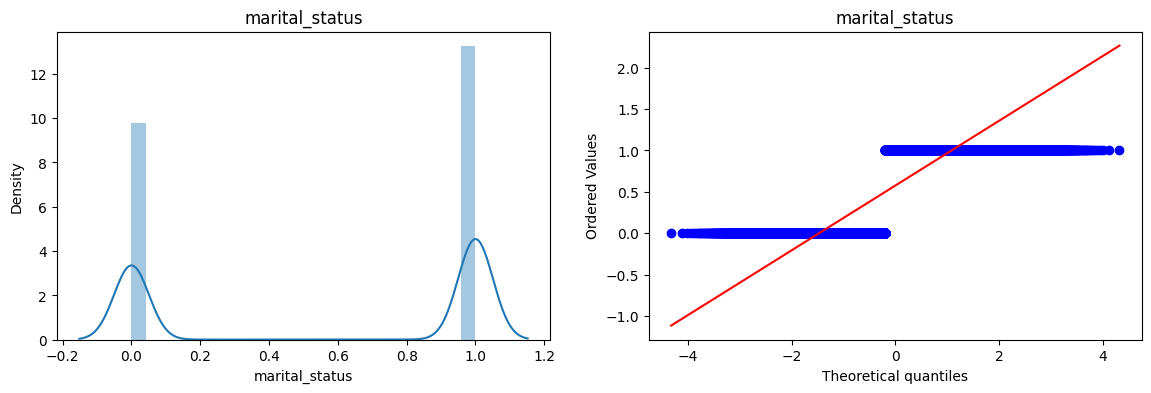

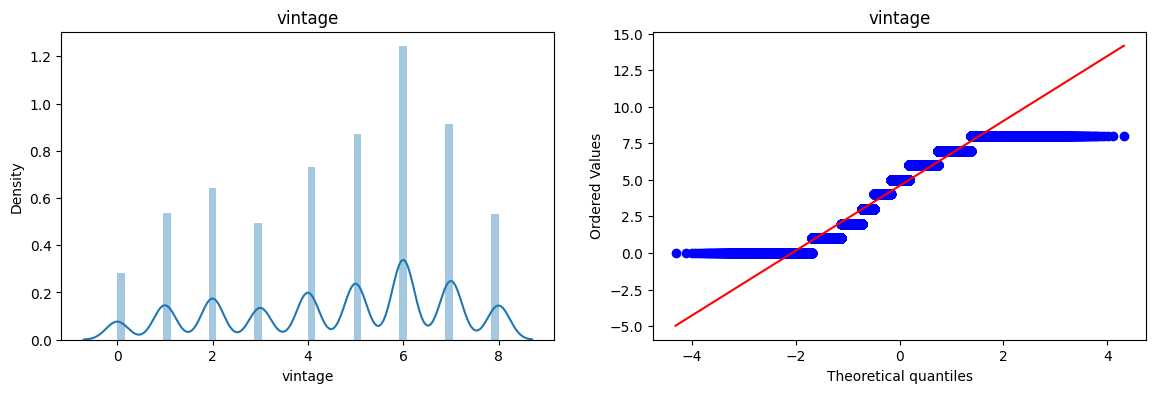

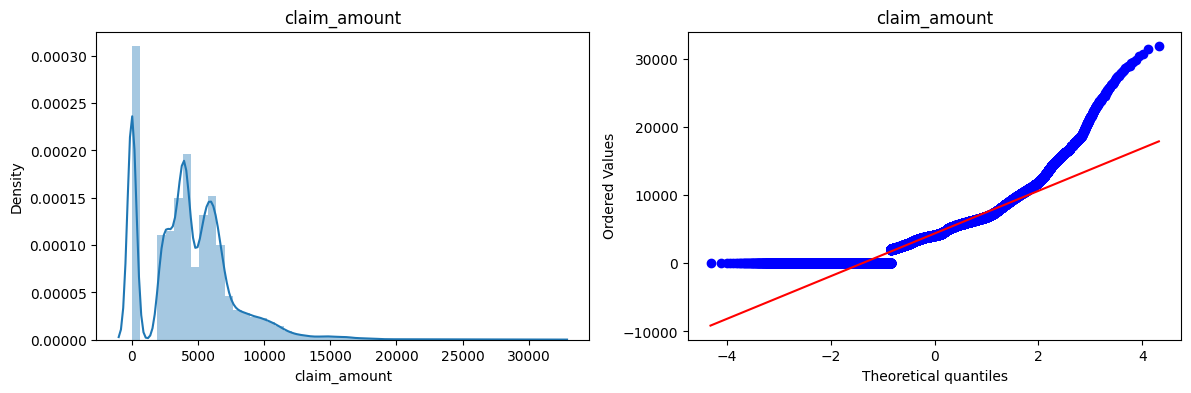

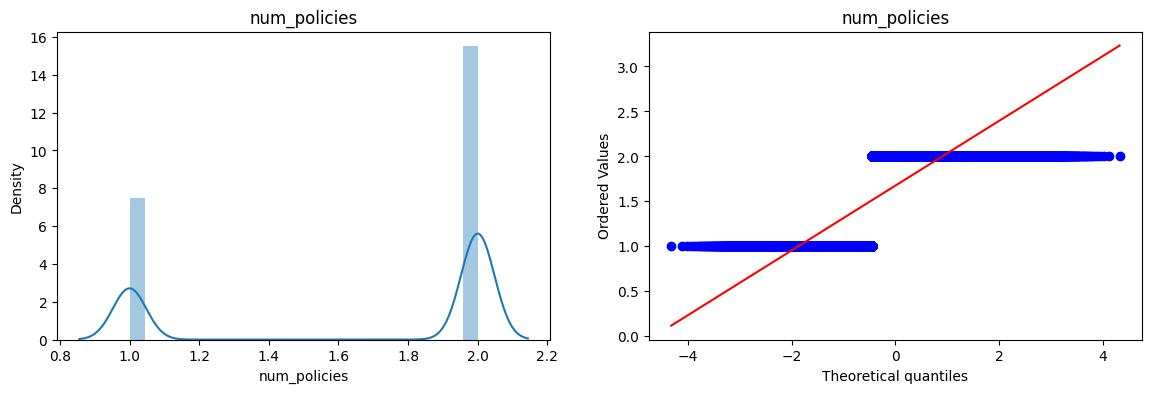

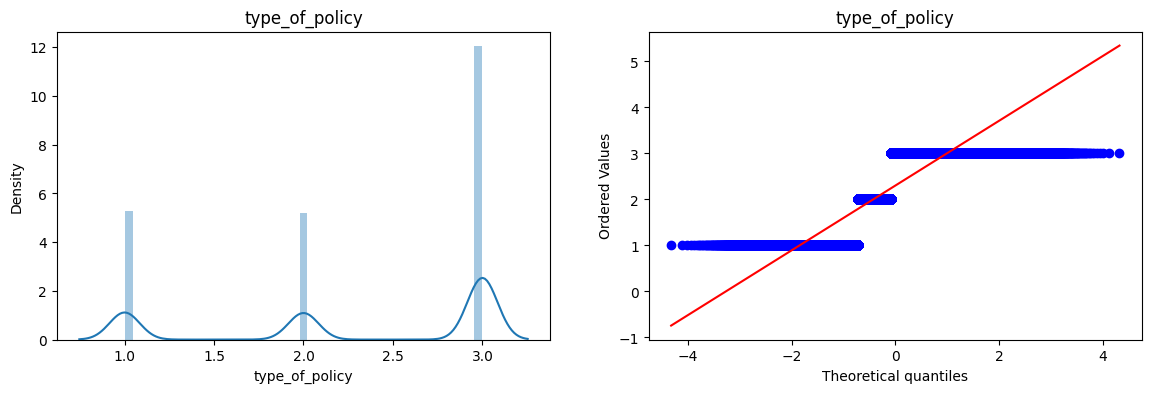

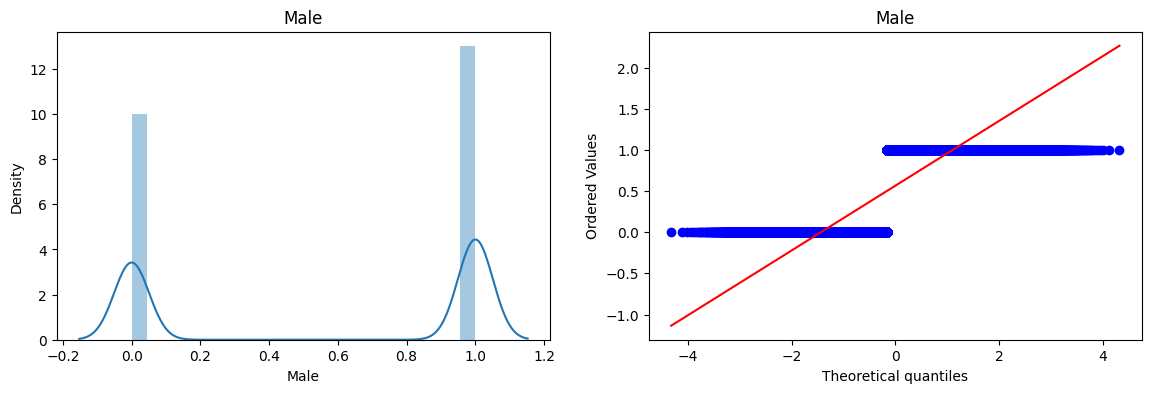

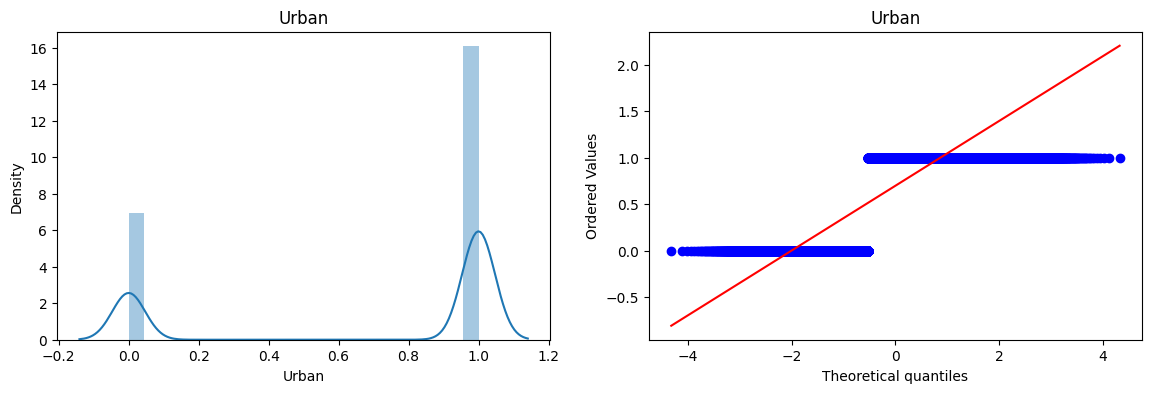

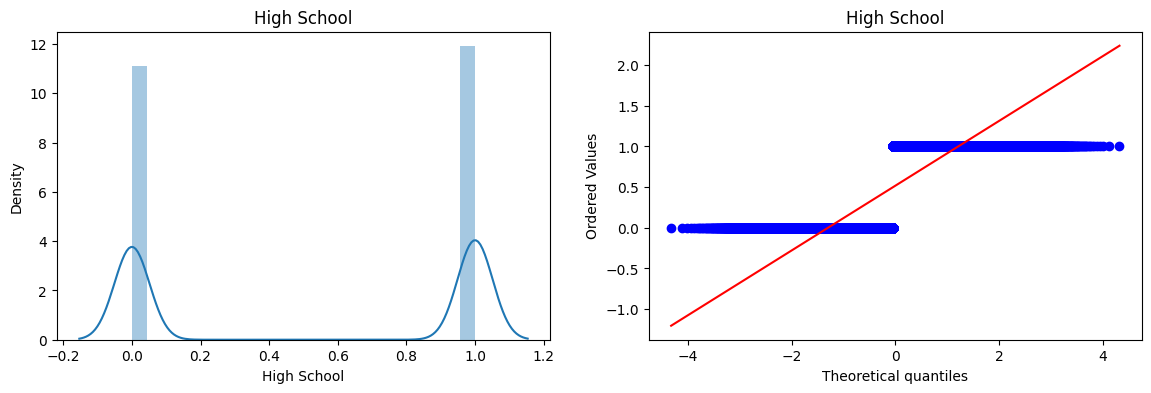

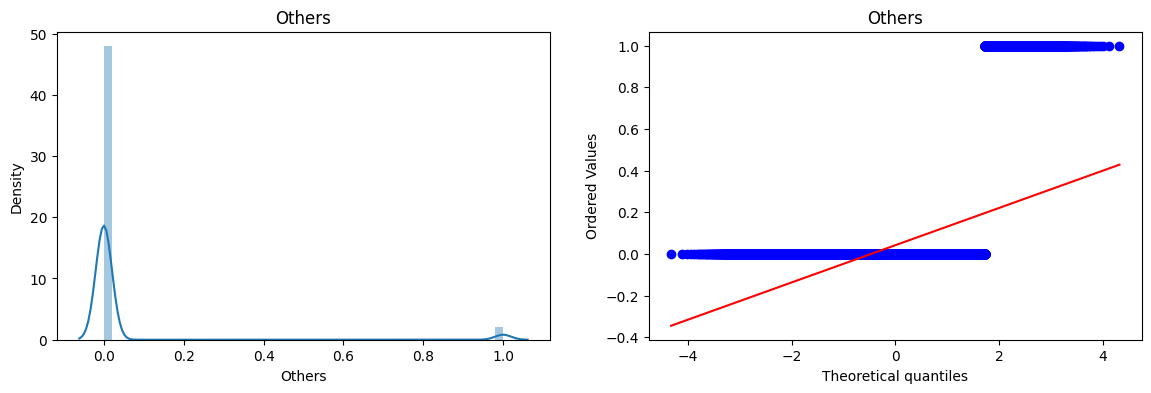

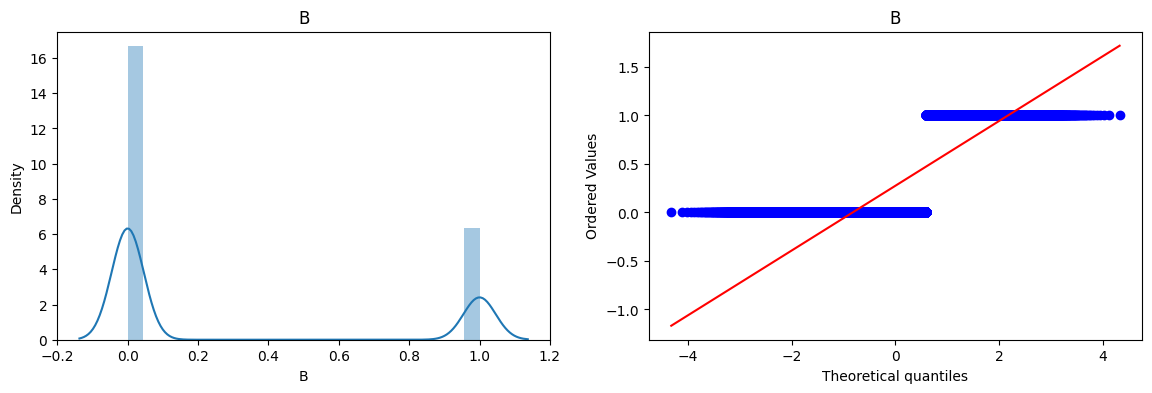

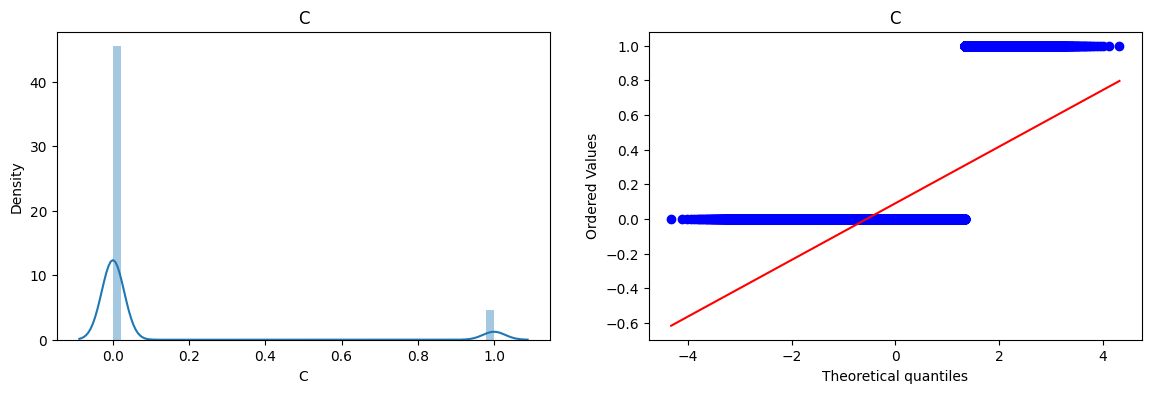

In [43]:
for col in X.columns:
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    sns.distplot(X[col])
    plt.title(col)

    plt.subplot(122)
    stats.probplot(X[col], dist="norm", plot=plt)
    plt.title(col)

    plt.show()

In [44]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

(71513, 12) (71513,) (17879, 12) (17879,)


In [45]:
std = StandardScaler()

Xtrain_transformed = std.fit_transform(Xtrain, ytrain)
Xtest_transformed = std.transform(Xtest)

In [46]:
Xtrain_transformed = pd.DataFrame(Xtrain_transformed, columns = Xtrain.columns)
Xtest_transformed = pd.DataFrame(Xtest_transformed, columns = Xtest.columns)

In [47]:
Xtrain_transformed

,income,marital_status,vintage,claim_amount,num_policies,type_of_policy,Male,Urban,High School,Others,B,C
0,1.666409,0.859112,0.612920,-0.698321,0.694337,-0.363529,0.874899,0.656073,-1.034302,4.752482,-0.617479,-0.316143
1,0.185320,0.859112,-0.697694,0.894067,-1.440223,0.850322,0.874899,0.656073,-1.034302,4.752482,1.619489,-0.316143
2,-2.776858,0.859112,0.612920,0.111031,-1.440223,0.850322,-1.142989,0.656073,0.966835,-0.210416,-0.617479,-0.316143
3,0.185320,-1.163993,0.612920,-1.332032,-1.440223,0.850322,-1.142989,0.656073,0.966835,-0.210416,-0.617479,-0.316143
4,0.185320,0.859112,0.176049,-1.332032,0.694337,-1.577379,-1.142989,0.656073,-1.034302,-0.210416,1.619489,-0.316143
...,...,...,...,...,...,...,...,...,...,...,...,...
71508,0.185320,0.859112,1.049791,-0.149981,-1.440223,0.850322,0.874899,0.656073,0.966835,-0.210416,1.619489,-0.316143
71509,0.185320,0.859112,0.176049,-0.644160,-1.440223,-1.577379,0.874899,-1.524221,-1.034302,-0.210416,-0.617479,-0.316143
71510,1.666409,-1.163993,1.049791,0.745966,0.694337,0.850322,-1.142989,0.656073,-1.034302,-0.210416,-0.617479,-0.316143
71511,1.666409,-1.163993,-2.008308,0.465982,-1.440223,-0.363529,0.874899,0.656073,-1.034302,4.752482,1.619489,-0.316143


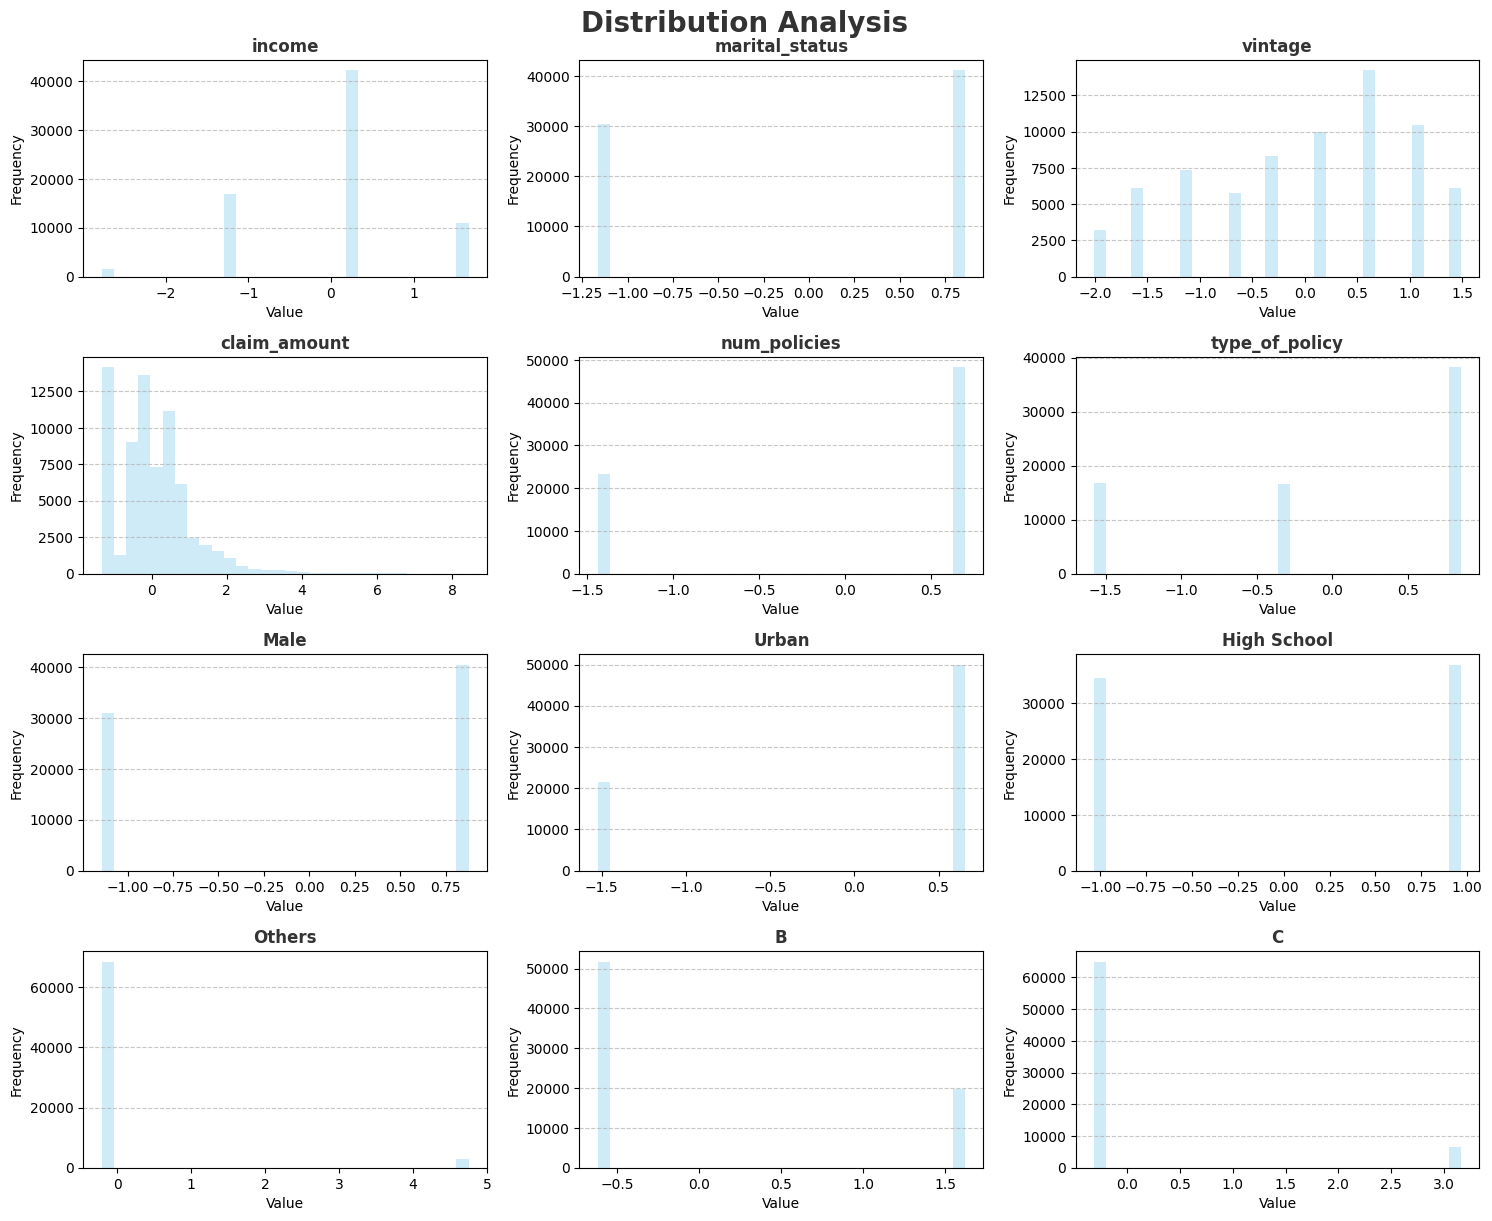

In [48]:
plt.figure(figsize=(15, 15))
plt.suptitle('Distribution Analysis', fontsize=20, fontweight='bold', alpha=0.8)

for i, column in enumerate(Xtrain_transformed.columns):
    plt.subplot(5, 3, i + 1)
    sns.distplot(Xtrain_transformed[column], kde=False, bins=30, color='skyblue')
    plt.title(column, fontsize=12, fontweight='bold', alpha=0.8)
    plt.xlabel('Value', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [49]:
VIF = pd.DataFrame(index = Xtrain_transformed.columns)
VIF['vif'] = [variance_inflation_factor(Xtrain_transformed,i) for i in range(X.shape[1])]

VIF

,vif
income,1.087762
marital_status,1.028600
vintage,1.012630
claim_amount,1.317350
num_policies,1.051153
type_of_policy,1.018174
Male,1.016889
Urban,1.330288
High School,1.064381
Others,1.057520


- All VIFs are very less. Hence, no need of any treatment. 

In [50]:
X.head()

,income,marital_status,vintage,claim_amount,num_policies,type_of_policy,Male,Urban,High School,Others,B,C
0,3,1,5,5790,2,3,1,1,0,0,0,0
1,3,0,8,5080,2,3,1,0,1,0,0,0
2,3,1,8,2599,2,3,1,1,0,0,0,0
3,3,0,7,0,2,3,0,0,1,0,0,0
4,4,1,6,3508,2,2,1,1,1,0,0,0


In [51]:
Xtrain.head()

,income,marital_status,vintage,claim_amount,num_policies,type_of_policy,Male,Urban,High School,Others,B,C
22085,4,1,6,2071,2,2,1,1,0,1,0,0
19413,3,1,3,7275,1,3,1,1,0,1,1,0
30309,1,1,6,4716,1,3,0,1,1,0,0,0
333,3,0,6,0,1,3,0,1,1,0,0,0
60407,3,1,5,0,2,1,0,1,0,0,1,0


In [52]:
Xtrain_transformed.head()

,income,marital_status,vintage,claim_amount,num_policies,type_of_policy,Male,Urban,High School,Others,B,C
0,1.666409,0.859112,0.612920,-0.698321,0.694337,-0.363529,0.874899,0.656073,-1.034302,4.752482,-0.617479,-0.316143
1,0.185320,0.859112,-0.697694,0.894067,-1.440223,0.850322,0.874899,0.656073,-1.034302,4.752482,1.619489,-0.316143
2,-2.776858,0.859112,0.612920,0.111031,-1.440223,0.850322,-1.142989,0.656073,0.966835,-0.210416,-0.617479,-0.316143
3,0.185320,-1.163993,0.612920,-1.332032,-1.440223,0.850322,-1.142989,0.656073,0.966835,-0.210416,-0.617479,-0.316143
4,0.185320,0.859112,0.176049,-1.332032,0.694337,-1.577379,-1.142989,0.656073,-1.034302,-0.210416,1.619489,-0.316143


In [53]:
Xtest.head()

,income,marital_status,vintage,claim_amount,num_policies,type_of_policy,Male,Urban,High School,Others,B,C
10600,3,1,5,3867,2,3,0,1,1,0,0,0
47569,3,0,2,5466,1,3,0,1,1,0,0,0
17246,4,1,5,2505,1,1,1,1,0,0,0,0
71237,3,1,8,0,2,2,0,0,1,0,0,0
64437,3,0,1,6643,2,1,0,1,1,0,0,0


In [54]:
Xtest_transformed.head()

,income,marital_status,vintage,claim_amount,num_policies,type_of_policy,Male,Urban,High School,Others,B,C
0,0.185320,0.859112,0.176049,-0.148757,0.694337,0.850322,-1.142989,0.656073,0.966835,-0.210416,-0.617479,-0.316143
1,0.185320,-1.163993,-1.134565,0.340525,-1.440223,0.850322,-1.142989,0.656073,0.966835,-0.210416,-0.617479,-0.316143
2,1.666409,0.859112,0.176049,-0.565520,-1.440223,-1.577379,0.874899,0.656073,-1.034302,-0.210416,-0.617479,-0.316143
3,0.185320,0.859112,1.486662,-1.332032,0.694337,-0.363529,-1.142989,-1.524221,0.966835,-0.210416,-0.617479,-0.316143
4,0.185320,-1.163993,-1.571437,0.700679,0.694337,-1.577379,-1.142989,0.656073,0.966835,-0.210416,-0.617479,-0.316143


## Algorithm Modelling

### Model - 1 : Linear Regression

In [90]:
lin_reg = LinearRegression()

In [91]:
lin_reg.fit(Xtrain_transformed, ytrain) 
ypred = lin_reg.predict(Xtest_transformed)

r2_score_lin_reg = r2_score(ytest, ypred)
print('R2 Score:', r2_score_lin_reg)

R2 Score: 0.15131877173369146


In [93]:
def adj_r2(x,y):
    r2 = r2_score(ytest, ypred)
    n = x.shape[0]
    p = x.shape[1]
    adjusted_r2 = 1-(((1-r2)*(n-1))/(n-p-1))
    
    return adjusted_r2

adj_r2_lin_reg = adj_r2(Xtest_transformed, ytest)
print('Adjusted R2 Score:', adj_r2_lin_reg)

Adjusted R2 Score: 0.15074874068369726


In [57]:
elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_net.fit(Xtrain_transformed, ytrain)
ypred = elastic_net.predict(Xtest_transformed)

r2_score_elastic_net = r2_score(ytest, ypred)
print('R2 Score:', r2_score_elastic_net)

R2 Score: 0.15110875608764807


In [78]:
file_path = os.path.join('C:/Users/rsk13/Desktop/CLTV_NEW', 'lin_reg.pkl')

with open(file_path, 'wb') as f:
    pickle.dump(lin_reg, f)

In [80]:
file_path = os.path.join('C:/Users/rsk13/Desktop/CLTV_NEW', 'elasticnet_reg.pkl')

with open(file_path, 'wb') as f:
    pickle.dump(elastic_net, f)

#### Checking the "Assumptions of Linear Regression"

##### 1. Linearity

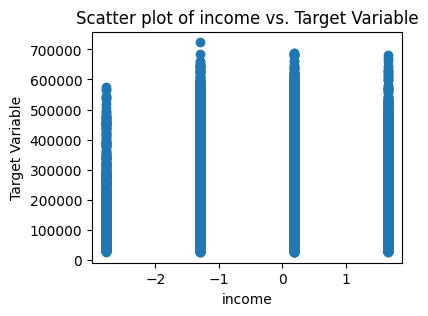

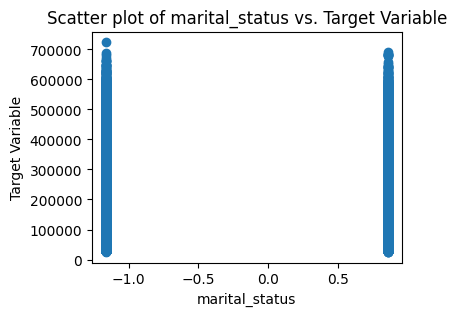

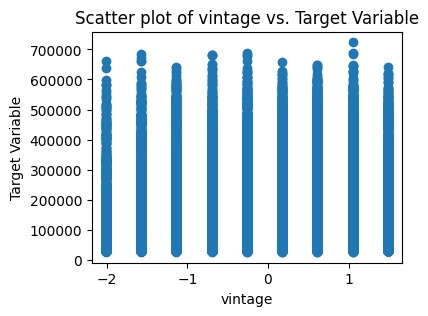

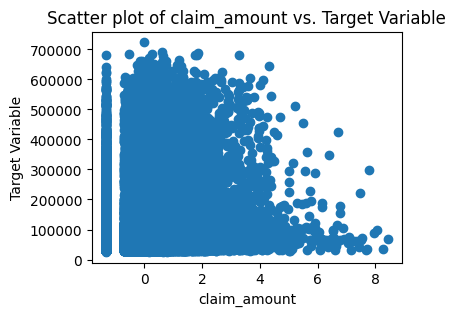

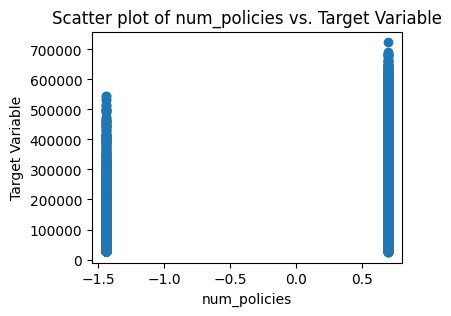

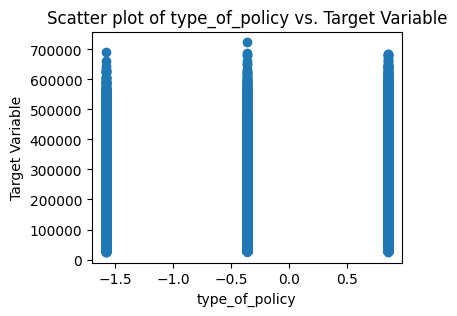

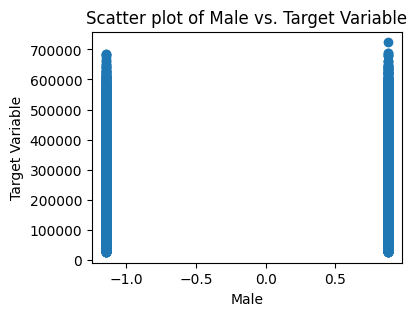

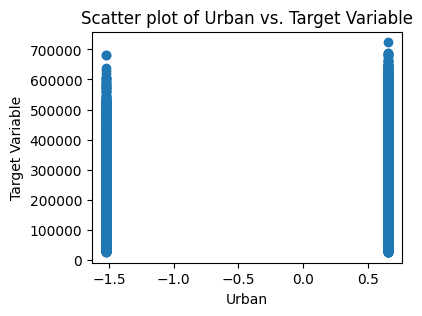

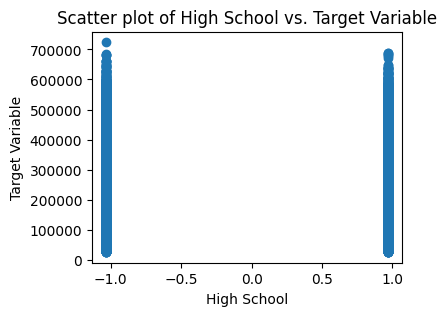

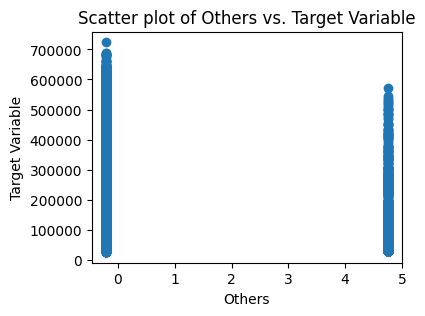

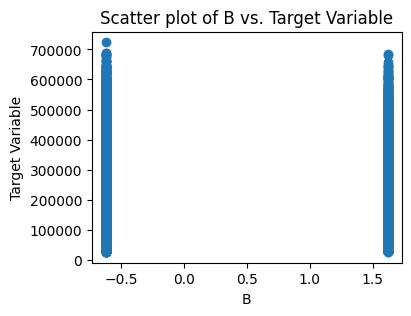

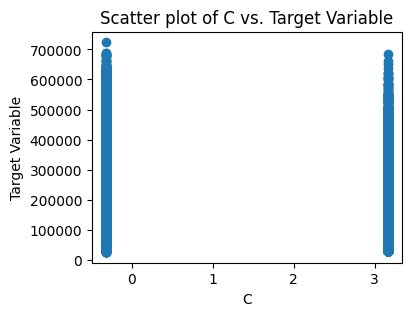

In [60]:
# Visual inspection of linearity using scatter plots
for col in Xtrain_transformed.columns:
    plt.figure(figsize = (4,3))
    plt.scatter(Xtrain_transformed[col], ytrain)
    plt.xlabel(col)
    plt.ylabel('Target Variable')
    plt.title(f'Scatter plot of {col} vs. Target Variable')
    plt.show()

### Observations for Linear and Elastic Net Regression:

1. While fitting the transformed data into the model, it could have been beneficial to check the assumptions for linear regression. However, given the manageable size of the dataset, proceeding directly with model fitting was a reasonable choice to assess model performance.

2. Despite this, the performance of the Linear Regression and Elastic Net models was unsatisfactory, prompting a closer examination of the assumptions for linear regression.

3. The first assumption of linear regression posits a linear relationship between independent and target variables. However, upon inspection, it was evident that this assumption was violated, as indicated by the presence of vertical lines spaced apart from each other, suggesting no linear relationship.

4. Consequently, it was decided not to proceed with these models and instead explore tree-based algorithms.

### 2. Random Forest

In [227]:
rf = RandomForestRegressor()

In [228]:
rf.fit(Xtrain_transformed, ytrain)
ypred = rf.predict(Xtest_transformed)

r2_score_rf = r2_score(ytest, ypred)
print('R2 Score:', r2_score_rf)

R2 Score: 0.03503931281874206


In [231]:
rf_train_cv = cross_val_score(rf, Xtrain_transformed, ytrain, cv = KFold(5), scoring = 'r2')
rf_test_cv = cross_val_score(rf, Xtest_transformed, ytest, cv = KFold(5), scoring = 'r2')

print('Train CV Score:', rf_train_cv.mean())
print('Test CV Score:', rf_test_cv.mean())

Train CV Score: 0.028967747690815247
Test CV Score: 0.0386176281677665


- The Random Forest model is also not performing well. 

- We will tune this model. 

##### Hyperparameter Tuning the Random Forest model

In [232]:
params = {
    'n_estimators' : [100, 200, 300, 400, 500],
    'max_depth' : [5, 10, 15, 20, 25],
    'min_samples_split' : [2, 5, 10, 15, 100],
    'min_samples_leaf' : [1, 2, 5, 10],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
}

In [234]:
tuned = RandomizedSearchCV(rf, params, cv = KFold(5), scoring = 'r2', n_jobs = -1)

In [235]:
tuned.fit(Xtrain_transformed, ytrain)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'friedman_mse',
                                                      'poisson'],
                                        'max_depth': [5, 10, 15, 20, 25],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   scoring='r2')

In [236]:
tuned.best_estimator_

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=100,
                      n_estimators=300)

In [96]:
tuned_rf = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=100,
                      n_estimators=300)

In [97]:
tuned_rf.fit(Xtrain_transformed, ytrain)
ypred = tuned_rf.predict(Xtest_transformed)

r2_score_tuned_rf = r2_score(ytest, ypred)
print('R2 Score:', r2_score_tuned_rf)

R2 Score: 0.15953563609029153


In [240]:
lgbm = lightgbm.LGBMRegressor()

lgbm.fit(Xtrain_transformed, ytrain)
ypred = lgbm.predict(Xtest_transformed)

r2_score_lgbm = r2_score(ytest, ypred)
print('R2 Score:', r2_score_lgbm)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 71513, number of used features: 12
[LightGBM] [Info] Start training from score 98194.843343
R2 Score: 0.1562898539203771


In [98]:
file_path = os.path.join('C:/Users/rsk13/Desktop/CLTV_NEW/model_weight', 'tuned_rf.pkl')

with open(file_path, 'wb') as f:
    pickle.dump(tuned_rf, f)

### 3. Deep Neural Network

In [61]:
print(len(tf.config.list_physical_devices('GPU')) > 0)

True


In [62]:
!nvidia-smi

Wed Feb 21 13:18:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.23                 Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8             10W /  105W |     119MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [66]:
model = Sequential()

# Input layer
model.add(Dense(14, activation='relu', kernel_initializer='he_uniform', input_dim=Xtrain_transformed.shape[1]))

# Hidden layers
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(256, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Output layer
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 14)                182       
                                                                 
 dense_7 (Dense)             (None, 64)                960       
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                      

In [69]:
early_stopping = EarlyStopping(
    monitor='val_mse',
    min_delta=0.003,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'dnn.h5',
    monitor='val_mse',
    mode='auto',
    verbose=1,
    save_best_only=True
)

In [70]:
history = model.fit(Xtrain_transformed, ytrain, batch_size=32, epochs=50, 
                    validation_data=(Xtest_transformed, ytest),
                    validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
2234/2235 [============================>.] - ETA: 0s - loss: 17783859200.0000 - mse: 17783859200.0000
Epoch 1: val_mse improved from inf to 17066787840.00000, saving model to dnn.h5
2235/2235 [==============================] - 28s 12ms/step - loss: 17788096512.0000 - mse: 17788096512.0000 - val_loss: 17066787840.0000 - val_mse: 17066787840.0000
Epoch 2/50
2235/2235 [==============================] - ETA: 0s - loss: 17218441216.0000 - mse: 17218441216.0000
Epoch 2: val_mse improved from 17066787840.00000 to 16324441088.00000, saving model to dnn.h5
2235/2235 [==============================] - 26s 12ms/step - loss: 17218441216.0000 - mse: 17218441216.0000 - val_loss: 16324441088.0000 - val_mse: 16324441088.0000
Epoch 3/50
2233/2235 [============================>.] - ETA: 0s - loss: 16311732224.0000 - mse: 16311732224.0000
Epoch 3: val_mse improved from 16324441088.00000 to 15243976704.00000, saving model to dnn.h5
2235/2235 [==============================] - 23s 10ms/step - lo

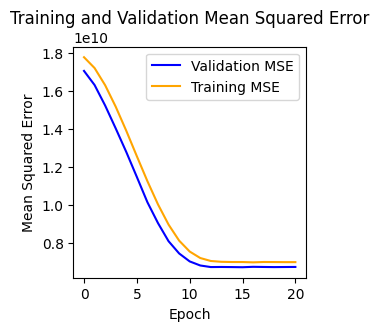

In [75]:
plt.figure(figsize=(3,3))

plt.plot(history.history['val_mse'], color='blue', label='Validation MSE')
plt.plot(history.history['mse'], color='orange', label='Training MSE')

plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Mean Squared Error')

plt.legend()

plt.show()

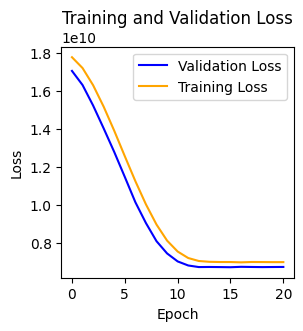

In [74]:
plt.figure(figsize=(3,3))

plt.plot(history.history['val_loss'], color='blue', label='Validation Loss')
plt.plot(history.history['loss'], color='orange', label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.legend()

plt.show()

In [94]:
y_pred = model.predict(Xtest_transformed)

r2_score_dnn = r2_score(ytest, y_pred)
print('R2 Score:', r2_score_dnn)

559/559 [==============================] - 1s 2ms/step
R2 Score: 0.15961619745814581


In [95]:
def adj_r2(x,y):
    r2 = r2_score(ytest, ypred)
    n = x.shape[0]
    p = x.shape[1]
    adjusted_r2 = 1-(((1-r2)*(n-1))/(n-p-1))
    
    return adjusted_r2

adj_r2_dnn = adj_r2(Xtest_transformed, ytest)
print('Adjusted R2 Score:', adj_r2_dnn)

Adjusted R2 Score: 0.15074874068369726


In [85]:
Xtrain_transformed.to_csv('transformed_data/Xtrain_transformed.csv', index = False)
ytrain.to_csv('transformed_data/ytrain.csv', index = False)

Xtest_transformed.to_csv('transformed_data/Xtest_transformed.csv', index = False)
ytest.to_csv('transformed_data/ytest.csv', index = False)